In [1]:
import numpy as np
from pandas.io.json import json_normalize
from sklearn.model_selection import cross_validate, train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import pandas as pd
data1 = pd.read_csv('tripadvisor_european_restaurants.csv', low_memory = False)
#data.head()

In [3]:
data = data1.copy()
data.head(3)

,restaurant_link,restaurant_name,original_location,country,region,province,city,address,latitude,longitude,...,excellent,very_good,average,poor,terrible,food,service,value,atmosphere,keywords
0,g10001637-d10002227,Le 147,"[""Europe"", ""France"", ""Nouvelle-Aquitaine"", ""Ha...",France,Nouvelle-Aquitaine,Haute-Vienne,Saint-Jouvent,"10 Maison Neuve, 87510 Saint-Jouvent France",45.961674,1.169131,...,2.0,0.0,0.0,0.0,0.0,4.0,4.5,4.0,NaN,NaN
1,g10001637-d14975787,Le Saint Jouvent,"[""Europe"", ""France"", ""Nouvelle-Aquitaine"", ""Ha...",France,Nouvelle-Aquitaine,Haute-Vienne,Saint-Jouvent,"16 Place de l Eglise, 87510 Saint-Jouvent France",45.957040,1.205480,...,2.0,2.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2,g10002858-d4586832,Au Bout du Pont,"[""Europe"", ""France"", ""Centre-Val de Loire"", ""B...",France,Centre-Val de Loire,Berry,Rivarennes,"2 rue des Dames, 36800 Rivarennes France",46.635895,1.386133,...,3.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN


In [4]:
data.columns

Index(['restaurant_link', 'restaurant_name', 'original_location', 'country',
       'region', 'province', 'city', 'address', 'latitude', 'longitude',
       'claimed', 'awards', 'popularity_detailed', 'popularity_generic',
       'top_tags', 'price_level', 'price_range', 'meals', 'cuisines',
       'special_diets', 'features', 'vegetarian_friendly', 'vegan_options',
       'gluten_free', 'original_open_hours', 'open_days_per_week',
       'open_hours_per_week', 'working_shifts_per_week', 'avg_rating',
       'total_reviews_count', 'default_language',
       'reviews_count_in_default_language', 'excellent', 'very_good',
       'average', 'poor', 'terrible', 'food', 'service', 'value', 'atmosphere',
       'keywords'],
      dtype='object')

In [5]:
data.shape

(1083397, 42)

# DATA CLEANING

    1.Drop column "popularity_generic" because its similar to "popularity_detailed". It only replaces 'Restaurants to eat' with 'Places to eat'. A place to eat can be taken to mean restaurant
    2. Drop "Original_location" column because where the restaurant originally started has little impact on its rating now. The current location is more important
    3. Over 25% of rows in the "price_level" columns are emmpty. There is no 3# and 2# ratings in the data

In [6]:
data['price_level'].isna().sum()/len(data)

0.2558665013840725

In [7]:
data['price_range'].value_counts(dropna = False)

NaN          779070
€10-€30        5937
€5-€15         5810
€10-€20        5148
€5-€20         4793
              ...  
€5-€2,242         1
€38-€63           1
€11-€113          1
€661-€862         1
€35-€180          1
Name: price_range, Length: 7299, dtype: int64

In [8]:
data['price_range'].isna().sum()/len(data)

0.7190992775501501

In [9]:
#data['city'].value_counts()

In [10]:
data['top_tags'].isna().sum()

110634

## Check restaurants with no ratings,  description and cuisines

In [11]:
restaurant_drop = data[(data['top_tags'].isna()) & (data['price_level'].isna())]
restaurant_drop.shape

(110617, 42)

In [12]:
data['top_tags'].value_counts(dropna = False)

NaN                                                            110634
Mid-range, French                                               20211
Mid-range                                                       19422
Cheap Eats                                                      15864
Mid-range, Italian                                              14363
                                                                ...  
Cheap Eats, Chinese, American, Asian                                1
Quick Bites, Chinese, Fast food, Sushi                              1
Bakeries, French, Spanish                                           1
Mid-range, International, Catalan, Vegetarian Friendly              1
Mid-range, Gastropub, Eastern European, Vegetarian Friendly         1
Name: top_tags, Length: 39963, dtype: int64

In [13]:
no_rating_restaurant = data[data['top_tags'].isna()]
no_rating_restaurant.shape

(110634, 42)

In [14]:
#pokemon_games = df.loc[df['Name'].str.contains("pokemon", case=False)]

## Its hard to fill out ratings without a description. These restaurants are a significant percentage of the data (10%). But even if i drop them, I still remain with enough sample data to build a recommender

In [15]:
len(no_rating_restaurant)/len(data)

0.10211769092954845

In [16]:
data = data[~data['top_tags'].isna()]
data.shape

(972763, 42)

## Remove bars and pubs

In [17]:
data = data[~data['top_tags'].str.contains('pub', case = False)]
data = data[~data['top_tags'].str.contains('bar', case = False)]
data.shape

(831905, 42)

## Remove restaurants with no Cuisine specified

In [18]:
print(data.shape)
data = data[data['cuisines'].notnull()]
data.shape

(831905, 42)


(774358, 42)

In [19]:
data['price_level'].isna().sum()

139834

In [20]:
# conditions = [
#     (df['Age'] < 20),
#     (df['Age'] >= 20) & (df['Age'] < 40),
#     (df['Age'] >= 40) & (df['Age'] < 59),
#     (df['Age'] >= 60)
# ]
# values = ['<20 years old', '20-39 years old', '40-59 years old', '60+ years old']
# df['Age Group'] = np.select(conditions, values)
# print(df)

In [21]:
data['price_level'].value_counts(dropna = False)

€€-€€€    421602
€         188360
NaN       139834
€€€€       24562
Name: price_level, dtype: int64

In [22]:
# Map Euro Counts to Numbers
# To be done before assigning Null values ratings. If done after, it will map all values that are not present
#in the mapping dictionary to NaN

data['price_level'] = data['price_level'].map({'€€-€€€':5,'€€€€':4,'€':1})
data['price_level'].value_counts(dropna = False)

5.0    421602
1.0    188360
NaN    139834
4.0     24562
Name: price_level, dtype: int64

In [23]:
# data = np.where(data['price_level'].isna(),label_rate(),data['price_level'])
# data['price_level'].isna().sum()
# data['price_level'] = data[data['price_level'].isna()].apply( data['cuisines'] : label_rate(data['cuisines']))

In [24]:
#data[data['price_level'] == 1]

In [25]:
rest_without_rating = data[(data['price_level'].isna()) & (~data['top_tags'].isna())]
rest_without_rating.shape

(139834, 42)

In [26]:
data['price_level'].value_counts(dropna = False)

5.0    421602
1.0    188360
NaN    139834
4.0     24562
Name: price_level, dtype: int64

In [27]:
#rest_without_rating.to_csv("E:\\SKUL\\PROGRAMMING_SKULS\\ironhack\\COURSE\\Final-Year-Project\\Final Data\\ratings.csv")

In [28]:
rest_without_rating['cuisines'].isna().sum()/len(rest_without_rating)

0.0

## Filling out ratings for restaurants without them
### Assumptions 
    1.Every restaurant with the tags 'french','italian','german', 'european','portuguese','american','international' cuisines is considered good and allocated a 3-Star rating
    2.Every restaurant with a cuisnine "Street food" is given a 1-Star rating

In [29]:
# Function for assigning a rating to the restaurants

three_star_labels = ['french','italian','german', 'european','portuguese','american','international','Japanese','Chinese']
one_start_labels = ['street food','pizza']
def label_rate(x):
    x = x.lower()
    if any(ext in x for ext in three_star_labels):
        return 3
    elif any(ext in x for ext in one_start_labels):
        return 1
    else:
        return 2      
    

In [30]:
# Get DF for restaurants without ratings but having cuisine types

rest_without_rating = rest_without_rating[~rest_without_rating['cuisines'].isna()]
rest_without_rating['price_level'] = rest_without_rating['cuisines'].apply(lambda x : label_rate(x))

In [31]:
#rest_without_rating.to_csv("E:\\SKUL\\PROGRAMMING_SKULS\\ironhack\\COURSE\\Final-Year-Project\\Final Data\\ratings.csv")
rest_without_rating['price_level'].isna().sum()

0

### Combine the two dataframes and fill the NaN in the original data with the assigned ratings
### After, delete the created dataframe to free up memory

In [32]:
#data.loc[rest_without_rating.index, :] = rest_without_rating[:]
data = data.combine_first(rest_without_rating)
del rest_without_rating

In [33]:
# Check if all NaN values have been filled out

print(data['price_level'].value_counts(dropna = False))
data['price_level'].isna().sum()

5.0    421602
1.0    198355
3.0     68170
2.0     61669
4.0     24562
Name: price_level, dtype: int64


0

In [34]:
#data.iloc[:1000].to_csv("E:\\SKUL\\PROGRAMMING_SKULS\\ironhack\\COURSE\\Final-Year-Project\\Final Data\\mydata.csv")

In [35]:
data.shape

(774358, 42)

# We have lost over 30% of our original data in this phase of data cleaning. I need a minimum of 500k restaurants

## Cleaning the meals column

In [36]:
data['meals'].isna().sum()/len(data)

0.39024843806094855

### About 39% of restaurants do not specify meal types
### We removed all pubs, bars and those serving only breakfast
### Safe to assume all our remaining restaurants atleast serve both lunch and dinner
### Fill all NaN in meals with Lunch, Dinner

In [37]:
data['meals'] = data['meals'].fillna('Lunch, Dinner')
data['meals'].isna().sum()

0

## Filter the restaurants that have bars
### Create column 'bar' with 1 - for restautants whose meals include the word 'Drinks' and 0 - for those that dont

In [38]:
# def with_bar(x):
#     if 'drinks' in x.lower():
#         return 1
#     else:
#         return 0

In [39]:
# data['bar'] = data['meals'].apply(lambda x: with_bar(x))
# data['bar'].value_counts(dropna = False)

In [40]:
# bar_list = ['alcohol', 'bar']
# regstr = '|'.join(bar_list)
# data['xx'] = data['features'].str.lower().str.contains(regstr)
# data['xx'].head()

In [41]:
data['features'] = data['features'].astype(str)

## Fileter out restaurants that have won awards
### Over 73% of restaurants have never won an award
### Count Number of awards by counting the commas that appear in the string and add 1

In [42]:
round(data['awards'].isna().sum()/len(data),2)

0.73

In [43]:
data['awards'].isna().sum()

568207

In [44]:
data['awards'].dtypes

dtype('O')

In [45]:
def awards(x):    
    if x!= 0:
        x = str(x)
        return (x.count(",")+1)
    else:
        return 0

In [46]:
#ASK JAN WHY I CANT FILL NaN WITH 0
data['awards'].fillna(0, inplace = True)
data['awards'] = data['awards'].apply(lambda x: awards(x))
data['awards'].value_counts(dropna = False)

0     568207
2      40174
1      38247
3      34357
4      25068
5      19606
6      16858
7      12740
8       9143
9       5785
10      2909
11      1254
12        10
Name: awards, dtype: int64

In [47]:
len(data[data['awards'] == 0])
#.replace(np.nan, 0)

568207

In [48]:
data['awards'].isna().sum()

0

In [49]:
all_data = data[~data['original_open_hours'].isna()]
all_data.shape

(428762, 42)

## Encoding 'features' Column
## My PC ran out of memory when i attempted to use onehot Encoding

In [50]:
data['reservations'] = np.where(data['features'].str.contains("Reservations", case=False, na=False), 1, 0)
data['seating'] = np.where(data['features'].str.contains("Seating", case=False, na=False), 1, 0)
data['wheel_chair'] = np.where(data['features'].str.contains("Wheelchair Accessible", case=False, na=False), 1, 0)
data['alcohol'] = np.where(data['features'].str.contains("Serves Alcohol", case=False, na=False), 1, 0)
data['credit_cards'] = np.where(data['features'].str.contains("Accepts Credit Cards", case=False, na=False), 1, 0)
data['table_service'] = np.where(data['features'].str.contains("Table Service", case=False, na=False), 1, 0)
data['takeout'] = np.where(data['features'].str.contains("Takeout", case=False, na=False), 1, 0)
data['outdoor'] = np.where(data['features'].str.contains("Outdoor Seating", case=False, na=False), 1, 0)
data['delivery'] = np.where(data['features'].str.contains("Delivery", case=False, na=False), 1, 0)
data['wifi'] = np.where(data['features'].str.contains("Free Wifi", case=False, na=False), 1, 0)
data['highchair'] = np.where(data['features'].str.contains("Highchairs Available", case=False, na=False), 1, 0)
data['full_bar'] = np.where(data['features'].str.contains("Full Bar", case=False, na=False), 1, 0)
data['parking'] = np.where(data['features'].str.contains("Parking Available", case=False, na=False), 1, 0)
data['street_parking'] = np.where(data['features'].str.contains("Free off-street parking", case=False, na=False), 1, 0)

In [51]:
#numerical = data.select_dtypes(include = np.number)
#numerical.columns

## Encoding 'original_open_hours' column. Its a dictionary with keys (days of week) and value (open hours)

### Program reads it as a string. Convert values from string to a dictionary
### Assign all restaurants with no time specified uniform hours

In [52]:
#data['original_open_hours'].value_counts(dropna = False)

In [53]:
# Below is the most commonly occuring working hours 

"""
{"Mon": ["00:00-23:59"], "Tue": ["00:00-23:59"], "Wed": ["00:00-23:59"], "Thu": ["00:00-23:59"], 
 "Fri": ["00:00-23:59"], "Sat": ["00:00-23:59"], "Sun": ["00:00-23:59"]}
"""

'\n{"Mon": ["00:00-23:59"], "Tue": ["00:00-23:59"], "Wed": ["00:00-23:59"], "Thu": ["00:00-23:59"], \n "Fri": ["00:00-23:59"], "Sat": ["00:00-23:59"], "Sun": ["00:00-23:59"]}\n'

In [54]:
import ast
x = {"Mon": ["00:00-23:59"], "Tue": ["00:00-23:59"], "Wed": ["00:00-23:59"], "Thu": ["00:00-23:59"],"Fri": ["00:00-23:59"], "Sat": ["00:00-23:59"], "Sun": ["00:00-23:59"]}  
#x = {"Mon": ["09:00-14:30"], "Tue": ["09:00-14:30", "19:00-21:30"], "Wed": ["09:00-14:30", "19:00-21:30"], "Thu": ["09:00-14:30", "19:00-21:30"], "Fri": ["09:00-14:30", "19:00-22:00"], "Sat": ["09:00-14:30", "19:00-22:00"], "Sun": ["09:00-16:00"]}
x = str(x)
x = x.replace('""', "''")
def convert_dict(l):
    if l != 0:
      return ast.literal_eval(l)  
    else:       
        return ast.literal_eval(x)

In [55]:
data['original_open_hours'].fillna(0, inplace = True)
data['original_open_hours'] = data['original_open_hours'].apply(lambda l : convert_dict(l))

## Fill out 'open_days_per_week' and 'open_hours_per_week' columns based on values
## in the 'original_open_hours' column
## For the assigned hours and from data exploration, days_per_week = 7, hours_per_week = 84 and working shifts = 7

In [56]:
ll = {"Mon": ["00:00-23:59"], "Tue": ["00:00-23:59"], "Wed": ["00:00-23:59"], "Thu": ["00:00-23:59"],"Fri": ["00:00-23:59"], "Sat": ["00:00-23:59"], "Sun": ["00:00-23:59"]} 
data['open_days_per_week'] = np.where(data['original_open_hours'] == ll,7,data['open_days_per_week'])
data['open_days_per_week'].head()

0    7.0
2    7.0
3    7.0
4    7.0
5    7.0
Name: open_days_per_week, dtype: float64

In [57]:
data['open_hours_per_week'] = np.where(data['original_open_hours'] == ll,84,data['open_hours_per_week'])
data['open_hours_per_week'].head()

0    84.0
2    84.0
3    84.0
4    84.0
5    53.5
Name: open_hours_per_week, dtype: float64

In [58]:
data['working_shifts_per_week'] = np.where(data['original_open_hours'] == ll,7,data['working_shifts_per_week'])
data['working_shifts_per_week'].head()

0     7.0
2     7.0
3     7.0
4     7.0
5    12.0
Name: working_shifts_per_week, dtype: float64

In [59]:
#df = data[data['original_open_hours'] != 0]
#df['Mon'] = df['original_open_hours'].apply(lambda x : x['Mon'])

In [60]:
data['mon'] = data['original_open_hours'].apply(lambda x : x['Mon'])
data['tue'] = data['original_open_hours'].apply(lambda x : x['Tue'])
data['wed'] = data['original_open_hours'].apply(lambda x : x['Wed'])
data['thur'] = data['original_open_hours'].apply(lambda x : x['Thu'])
data['fri'] = data['original_open_hours'].apply(lambda x : x['Fri'])
data['sat'] = data['original_open_hours'].apply(lambda x : x['Sat'])
data['sun'] = data['original_open_hours'].apply(lambda x : x['Sun'])

In [61]:
data[['mon','tue','wed']].head()

,mon,tue,wed
0,[00:00-23:59],[00:00-23:59],[00:00-23:59]
2,[00:00-23:59],[00:00-23:59],[00:00-23:59]
3,[00:00-23:59],[00:00-23:59],[00:00-23:59]
4,[00:00-23:59],[00:00-23:59],[00:00-23:59]
5,[09:00-14:30],"[09:00-14:30, 19:00-21:30]","[09:00-14:30, 19:00-21:30]"


# Encoding 'default_language' column
## Using Web scrapping to get official languages of European countries from Wikipedia
## Assign restaurants the official country language of the countries where they are located
### Over 47,000 restaurants are not assigned a language 

In [62]:
data['default_language'].value_counts(dropna = False)

English          522125
All languages    204381
NaN               47852
Name: default_language, dtype: int64

In [63]:
import requests
from bs4 import BeautifulSoup


In [64]:
uri = 'https://en.wikipedia.org/wiki/Languages_of_the_European_Union'
response = requests.get(uri)
soup = BeautifulSoup(response.content, 'html.parser')
#soup

In [65]:
countries = []
languages = []
for i in range(3,27):
    language  =(soup.select("#mw-content-text > div.mw-parser-output > table:nth-child(16) > tbody > tr:nth-child(" + str(i) + ") > td:nth-child(1) > a")[0].text)
    country = soup.select("#mw-content-text > div.mw-parser-output > table:nth-child(16) > tbody > tr:nth-child(" + str(i) + ") > td:nth-child(2)")[0].text.replace('\n','')
    #count = len(country.split()) --> DOES NOT WORK. SOME COUNTRIES HAVE DOUBLE SPACES
    count = country.count(' ')   
    if count > 1 and 'Czech' not in country:
        countries.append(country.split())
        languages.append(language)
    else:
        languages.append(language)
        countries.append(country)


In [66]:
print(languages)
print(countries)

['Bulgarian', 'Croatian', 'Czech', 'Danish', 'Dutch', 'English', 'Estonian', 'Finnish', 'French', 'German', 'Greek', 'Hungarian', 'Irish', 'Italian', 'Latvian', 'Lithuanian', 'Maltese', 'Polish', 'Portuguese', 'Romanian', 'Slovak', 'Slovene', 'Spanish', 'Swedish']
['Bulgaria', 'Croatia', 'Czech Republic', 'Denmark', ['Belgium', 'Netherlands'], ['Ireland', 'Malta'], 'Estonia', 'Finland', ['Belgium', 'France', 'Luxembourg'], ['Austria', 'Belgium', 'Germany', 'Luxembourg'], ['Cyprus', 'Greece'], 'Hungary', 'Ireland', 'Italy', 'Latvia', 'Lithuania', 'Malta', 'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia', 'Spain', ['Sweden', 'Finland']]


## Cleaning the lists
### There are languages spoken by multiple countries
###  Belgium and Finland have more than one official language
### Countries that appear more than twice are assigned the last instance where they appear (Ireland & Malta)

In [67]:
countries_and_languages = {}
for country in countries:
    for language in languages:
        if isinstance(country, list) == True:
            for i in range(len(country)):
                countries_and_languages[country[i]] = language
            languages.remove(language)
            break
            
        else:
            countries_and_languages[country] = language
            languages.remove(language)
            break
        

### The UK, Scotland, Wales and Northern Ireland are not part of the European Union but i want to include them in recommender
### Fortunately, they all speak the same language. Will append them to the language dictionary

In [68]:
uk_countries = ['England','Scotland','Wales','Northern Ireland']
for country in uk_countries:
    countries_and_languages[country] = 'English'
countries_and_languages

{'Bulgaria': 'Bulgarian',
 'Croatia': 'Croatian',
 'Czech Republic': 'Czech',
 'Denmark': 'Danish',
 'Belgium': 'German',
 'Netherlands': 'Dutch',
 'Ireland': 'Irish',
 'Malta': 'Maltese',
 'Estonia': 'Estonian',
 'Finland': 'Swedish',
 'France': 'French',
 'Luxembourg': 'German',
 'Austria': 'German',
 'Germany': 'German',
 'Cyprus': 'Greek',
 'Greece': 'Greek',
 'Hungary': 'Hungarian',
 'Italy': 'Italian',
 'Latvia': 'Latvian',
 'Lithuania': 'Lithuanian',
 'Poland': 'Polish',
 'Portugal': 'Portuguese',
 'Romania': 'Romanian',
 'Slovakia': 'Slovak',
 'Slovenia': 'Slovene',
 'Spain': 'Spanish',
 'Sweden': 'Swedish',
 'England': 'English',
 'Scotland': 'English',
 'Wales': 'English',
 'Northern Ireland': 'English'}

### I am populating a column based on values of another column
### Create a new dataframe, fill the NaN in 'default_language' column based on values in the 'country' column
### There are no NaNs in the 'country' column

In [69]:
# Check for NaN in 'country' column
display(data['country'].isna().sum())
country_data = data[data['default_language'].isna()]
len(country_data)

0

47852

In [70]:
def clean_country(x):
    if x == 'The Netherlands':
        return 'Netherlands'
    else:
        return x

In [71]:
country_data['country'] = country_data['country'].apply(lambda x : clean_country(x))
country_data['country'].value_counts(dropna = False)

C:\Users\KIMERA\AppData\Local\Temp/ipykernel_9052/3065780036.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_data['country'] = country_data['country'].apply(lambda x : clean_country(x))


Spain               7631
Italy               7239
France              5549
Germany             5410
England             5153
Poland              2130
Portugal            2085
Greece              1959
Netherlands         1428
Czech Republic      1218
Austria             1128
Romania             1085
Belgium             1067
Sweden               830
Hungary              494
Finland              492
Ireland              491
Denmark              465
Bulgaria             450
Slovakia             422
Scotland             405
Croatia              355
Wales                244
Northern Ireland     122
Name: country, dtype: int64

In [72]:
def languages(x):
    #x = str(x)
    return countries_and_languages[x]

In [73]:
country_data['default_language'] = country_data['country'].apply(lambda x : countries_and_languages[x])

C:\Users\KIMERA\AppData\Local\Temp/ipykernel_9052/3434592492.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_data['default_language'] = country_data['country'].apply(lambda x : countries_and_languages[x])


In [74]:
country_data['default_language'].value_counts(dropna = False)

Spanish       7631
German        7605
Italian       7239
English       5924
French        5549
Polish        2130
Portuguese    2085
Greek         1959
Dutch         1428
Swedish       1322
Czech         1218
Romanian      1085
Hungarian      494
Irish          491
Danish         465
Bulgarian      450
Slovak         422
Croatian       355
Name: default_language, dtype: int64

### Merge the two dataframes 
### After, delete the 'country_data' dataframe o save memory

In [75]:
data = data.combine_first(country_data)
len(data[data['default_language'].isna()])

0

In [76]:
del country_data

## Cleaning the Average rating column
### Only 6% of restaurants do not have ratings
### Its small enough to be filled with the mean value

In [77]:
data['avg_rating'].isna().sum()/len(data)

0.06321107291459506

In [78]:
data['avg_rating'].fillna(np.mean(data['avg_rating']), inplace = True)
data['avg_rating'].isna().sum()/len(data)

0.0

## Check for NaN in the various reviews columns
### All columns have the same percentage of NaN values (6%)
### It is assumed that these restaurants have just not received any reviews

In [79]:
reviews_df = data[['reviews_count_in_default_language','excellent','very_good','average','poor','terrible']]
round(reviews_df.isna().sum()/len(data),2)

reviews_count_in_default_language    0.06
excellent                            0.06
very_good                            0.06
average                              0.06
poor                                 0.06
terrible                             0.06
dtype: float64

In [80]:
# DELETE DATAFRAME TO SAVE MEMORY
del reviews_df

## Processing Vegan Options

In [81]:
vegans_columns = ['vegetarian_friendly','vegan_options','gluten_free']
for col in vegans_columns:
    data[col] = data[col].map({'Y':1,'N':0})


In [82]:

data['vegan_options'].value_counts(dropna = False)

0    661754
1    112604
Name: vegan_options, dtype: int64

In [83]:
data['gluten_free'].value_counts(dropna = False)

0    678507
1     95851
Name: gluten_free, dtype: int64

In [84]:
data['vegetarian_friendly'].value_counts(dropna = False)

0    508622
1    265736
Name: vegetarian_friendly, dtype: int64

## Process the Claimed Column
### Claimed - Restaurant owners manages the account, post new content and respond to reviews
### Unclaimed - The account is unmanaged and reviews do not get responses
### Over 52.8% of restaurants are unclaimed

In [85]:
unclaimed_perc = len(data[data['claimed'] == 'Unclaimed'])/len(data)
unclaimed_perc

0.528628877082693

In [86]:
data['claimed'] = data['claimed'].map({'Claimed':1,'Unclaimed':0})
data['claimed'].value_counts(dropna = False)

0    409348
1    365010
Name: claimed, dtype: int64

In [87]:
#data.iloc[:1000].to_csv("E:\\SKUL\\PROGRAMMING_SKULS\\ironhack\\COURSE\\Final-Year-Project\\Final Data\\mydata.csv")

In [88]:
data['price_range'].dtypes

dtype('O')

# USING MACHINE LEARNING
## Applying Linear Regression to predict and fillout the missing values in the 'lower_limit' column

In [89]:
# REPLACE THE EUROS SIGN
data['price_range'] = data['price_range'].str.replace('€','')
data['price_range'].iloc[:10]

0       NaN
2       NaN
3       NaN
4       NaN
5     14-29
6      8-17
7     10-35
8     12-26
10      NaN
11      NaN
Name: price_range, dtype: object

In [90]:
# GET THE LOWER LIMIT
data['lower_limit'] = data['price_range'].apply(lambda x : str(x).split('-')[0])
data['lower_limit'].head(10)

0     nan
2     nan
3     nan
4     nan
5      14
6       8
7      10
8      12
10    nan
11    nan
Name: lower_limit, dtype: object

## Switzerland doesnot use EUROS. Swiss use Swiss Francs
### Processing the swiss francs

In [91]:
def swiss_francs(x):
    y = str(x)
    if 'CHF' in y:
        # Keep the last two characters on the string
        m = y[-2:]
        #m = y.replace("CHF"+"\\xa","")
        z = int(m) * 0.96
        return z
    else:
        return y
data['lower_limit'] = data['lower_limit'].apply(lambda x: swiss_francs(x))
data['lower_limit'] = data['lower_limit'].apply(lambda x: str(x).replace(",",""))
data['lower_limit'] = data['lower_limit'].astype(float).round(2)

### Convert 'nan' back to proper NaN => Its just a text

In [92]:
data['lower_limit'] = data['lower_limit'].replace('nan',np.nan)
data['lower_limit'].head(7)

0     NaN
2     NaN
3     NaN
4     NaN
5    14.0
6     8.0
7    10.0
Name: lower_limit, dtype: float64

In [93]:
data['lower_limit'].isna().sum()

530295

In [94]:
data['lower_limit'].value_counts()

5.0       26766
10.0      25050
2.0       22750
3.0       20751
6.0       15319
          ...  
1390.0        1
583.0         1
743.0         1
1212.0        1
174.0         1
Name: lower_limit, Length: 371, dtype: int64

In [95]:
#data['lower_limit'].fillna(0, inplace = True)
#data['lower_limit'] = data['lower_limit'].astype(float)
data['lower_limit'].dtypes

dtype('float64')

## Fillout 100k rows to be used in training the ML model

In [96]:
data['price_level'].value_counts()

5.0    421602
1.0    198355
3.0     68170
2.0     61669
4.0     24562
Name: price_level, dtype: int64

## Getting mean of various ratings (from 5-start to 1-star)

In [97]:
data_copy = data.iloc[:100000]
data_copy.shape

(100000, 64)

In [98]:
data_copy['lower_limit'] = data_copy['lower_limit'].replace('nan',np.nan)

C:\Users\KIMERA\AppData\Local\Temp/ipykernel_9052/1769149559.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_copy['lower_limit'] = data_copy['lower_limit'].replace('nan',np.nan)


In [99]:
five_mean = np.mean(data_copy['lower_limit'][(data_copy['price_level']== 5.0) & (~data_copy['lower_limit'].isna())])
five_mean

11.429796312869152

In [100]:
four_mean = np.mean(data_copy['lower_limit'][(data_copy['price_level']== 4.0) & (~data_copy['lower_limit'].isna())])
four_mean

31.078733252131553

In [101]:
three_mean = np.mean(data_copy['lower_limit'][(data_copy['price_level']== 3.0) & (~data_copy['lower_limit'].isna())])
three_mean

11.606060606060606

In [102]:
two_mean = np.mean(data_copy['lower_limit'][(data_copy['price_level']== 2.0) & (~data_copy['lower_limit'].isna())])
two_mean

8.0

In [103]:
one_mean = np.mean(data_copy['lower_limit'][(data_copy['price_level']== 1.0) & (~data_copy['lower_limit'].isna())])
one_mean

6.53869061413673

## Fill all NaN with the respective mean depending on the value in the 'price_level' column

In [104]:
def fill_out(x):
    if x == 5.0:
        return five_mean
    if x == 4.0:
        return four_mean
    if x == 3.0:
        return three_mean
    if x == 2.0:
        return two_mean
    if x == 1.0:
        return one_mean

In [105]:
# CREATE DATAFRAME WHERE 'lower_limit' IS NaN
null_df = data_copy[data_copy['lower_limit'].isna()]
len(null_df)

62659

In [106]:
null_df['lower_limit'] = null_df['price_level'].apply(lambda x: fill_out(x))
null_df['lower_limit'].iloc[:10]

C:\Users\KIMERA\AppData\Local\Temp/ipykernel_9052/1183878958.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  null_df['lower_limit'] = null_df['price_level'].apply(lambda x: fill_out(x))


0      6.538691
2      6.538691
3      6.538691
4     11.429796
10    11.429796
11     6.538691
12     8.000000
13    11.606061
16    11.429796
17    11.429796
Name: lower_limit, dtype: float64

## Merge the Dataframe
### Note: After the merge, All NaN are filled

In [107]:
data_copy = data_copy.combine_first(null_df)
del null_df

In [108]:
data_copy['lower_limit'].isna().sum()

0

# MODEL EXPLAINED
### I will train the model on the first 100k rows of data where all the NaN in the target variable (lower_limit) are filled out
### I will predict the empty values in the remaining rows that are empty

In [114]:
# USE ALL NUMERICAL COLUMNS
numericals = data_copy.select_dtypes(include = np.number)
print(numericals.shape)
numericals.columns

(100000, 38)


Index(['latitude', 'longitude', 'claimed', 'awards', 'price_level',
       'vegetarian_friendly', 'vegan_options', 'gluten_free',
       'open_days_per_week', 'open_hours_per_week', 'working_shifts_per_week',
       'avg_rating', 'total_reviews_count',
       'reviews_count_in_default_language', 'excellent', 'very_good',
       'average', 'poor', 'terrible', 'food', 'service', 'value', 'atmosphere',
       'reservations', 'seating', 'wheel_chair', 'alcohol', 'credit_cards',
       'table_service', 'takeout', 'outdoor', 'delivery', 'wifi', 'highchair',
       'full_bar', 'parking', 'street_parking', 'lower_limit'],
      dtype='object')

In [115]:
if 'lower_limit' in numericals.columns:
    print("FOUND IT")

FOUND IT


## NORMALIZE THE NUMERICAL DATA USING MINMAXSCALER
### We have a number of columns with only 0 & 1. They will not be affected by the transformer

In [116]:
# FILL NaN WITH ZEROS

numericals.fillna(0, inplace = True)
numericals.isna().sum()

C:\Users\KIMERA\.conda\envs\iron_hack_DA\lib\site-packages\pandas\core\frame.py:5176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


latitude                             0
longitude                            0
claimed                              0
awards                               0
price_level                          0
vegetarian_friendly                  0
vegan_options                        0
gluten_free                          0
open_days_per_week                   0
open_hours_per_week                  0
working_shifts_per_week              0
avg_rating                           0
total_reviews_count                  0
reviews_count_in_default_language    0
excellent                            0
very_good                            0
average                              0
poor                                 0
terrible                             0
food                                 0
service                              0
value                                0
atmosphere                           0
reservations                         0
seating                              0
wheel_chair              

In [117]:
from sklearn.preprocessing import MinMaxScaler
kimera = MinMaxScaler().fit(numericals)
x_normalized = kimera.transform(numericals)
print(x_normalized.shape)
x_normalized = pd.DataFrame(x_normalized,columns=numericals.columns)
x_normalized.head()

(100000, 38)


,latitude,longitude,claimed,awards,price_level,vegetarian_friendly,vegan_options,gluten_free,open_days_per_week,open_hours_per_week,...,table_service,takeout,outdoor,delivery,wifi,highchair,full_bar,parking,street_parking,lower_limit
0,0.899694,0.427901,1.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.505263,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003846
1,0.912892,0.442717,1.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.505263,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003846
2,0.893449,0.472644,1.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.505263,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003846
3,0.865383,0.550205,0.0,0.000000,1.0,0.0,0.0,0.0,1.0,0.505263,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.006723
4,0.903769,0.611335,1.0,0.181818,1.0,0.0,0.0,0.0,1.0,0.321805,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.008235


In [118]:
# import statsmodels.api as sm
# X_added_constant = sm.add_constant(X)
# model = sm.OLS(y,X_added_constant).fit()
# model.summary()

In [119]:
correlations_matrix = data.corr()
correlations_matrix

,latitude,longitude,claimed,awards,price_level,vegetarian_friendly,vegan_options,gluten_free,open_days_per_week,open_hours_per_week,...,table_service,takeout,outdoor,delivery,wifi,highchair,full_bar,parking,street_parking,lower_limit
latitude,1.000000,0.085452,-0.086900,-0.060695,-0.017829,0.042016,0.002491,-0.025305,-0.017770,-0.082877,...,-0.116168,0.038789,-0.075352,0.038415,-0.025298,0.004884,-0.050717,-0.000250,-0.006408,-0.001230
longitude,0.085452,1.000000,-0.026390,-0.031669,-0.001033,0.018781,-0.031190,-0.060981,0.057570,0.099648,...,-0.066099,-0.058796,-0.017562,-0.036783,-0.018926,-0.056237,-0.063490,-0.006628,0.004303,-0.003307
claimed,-0.086900,-0.026390,1.000000,0.336812,0.232755,0.292623,0.273276,0.297433,-0.280925,-0.333542,...,-0.048831,0.004855,0.106064,0.019998,0.163300,0.121120,0.125125,0.112162,0.103728,0.001057
awards,-0.060695,-0.031669,0.336812,1.000000,0.220186,0.439295,0.444601,0.551205,-0.159220,-0.251456,...,0.004930,-0.022949,0.091518,-0.023196,0.116392,0.164621,0.152037,0.050029,0.014534,-0.001193
price_level,-0.017829,-0.001033,0.232755,0.220186,1.000000,0.223698,0.149397,0.211223,-0.097914,-0.136925,...,0.106658,-0.115918,0.069623,-0.048621,0.035938,0.088051,0.092961,0.022559,0.006395,-0.003681
vegetarian_friendly,0.042016,0.018781,0.292623,0.439295,0.223698,1.000000,0.543754,0.452683,-0.116969,-0.198235,...,-0.233502,-0.136093,-0.089531,-0.047731,0.009461,-0.014066,0.005759,-0.055101,-0.032672,-0.001655
vegan_options,0.002491,-0.031190,0.273276,0.444601,0.149397,0.543754,1.000000,0.551077,-0.085966,-0.153636,...,-0.090289,-0.047776,-0.008855,-0.009874,0.083507,0.067066,0.077061,-0.006604,0.002068,-0.001051
gluten_free,-0.025305,-0.060981,0.297433,0.551205,0.211223,0.452683,0.551077,1.000000,-0.105193,-0.179169,...,-0.062540,-0.042620,0.011744,-0.015159,0.108590,0.095280,0.109736,0.008695,0.009889,-0.000971
open_days_per_week,-0.017770,0.057570,-0.280925,-0.159220,-0.097914,-0.116969,-0.085966,-0.105193,1.000000,0.624256,...,0.026524,0.021527,-0.014158,0.011767,-0.027435,-0.022736,-0.018886,-0.036340,-0.043073,0.001238
open_hours_per_week,-0.082877,0.099648,-0.333542,-0.251456,-0.136925,-0.198235,-0.153636,-0.179169,0.624256,1.000000,...,0.050398,0.003007,0.006186,-0.024736,-0.017980,-0.047599,-0.000115,-0.040666,-0.035954,0.001577


<AxesSubplot:>

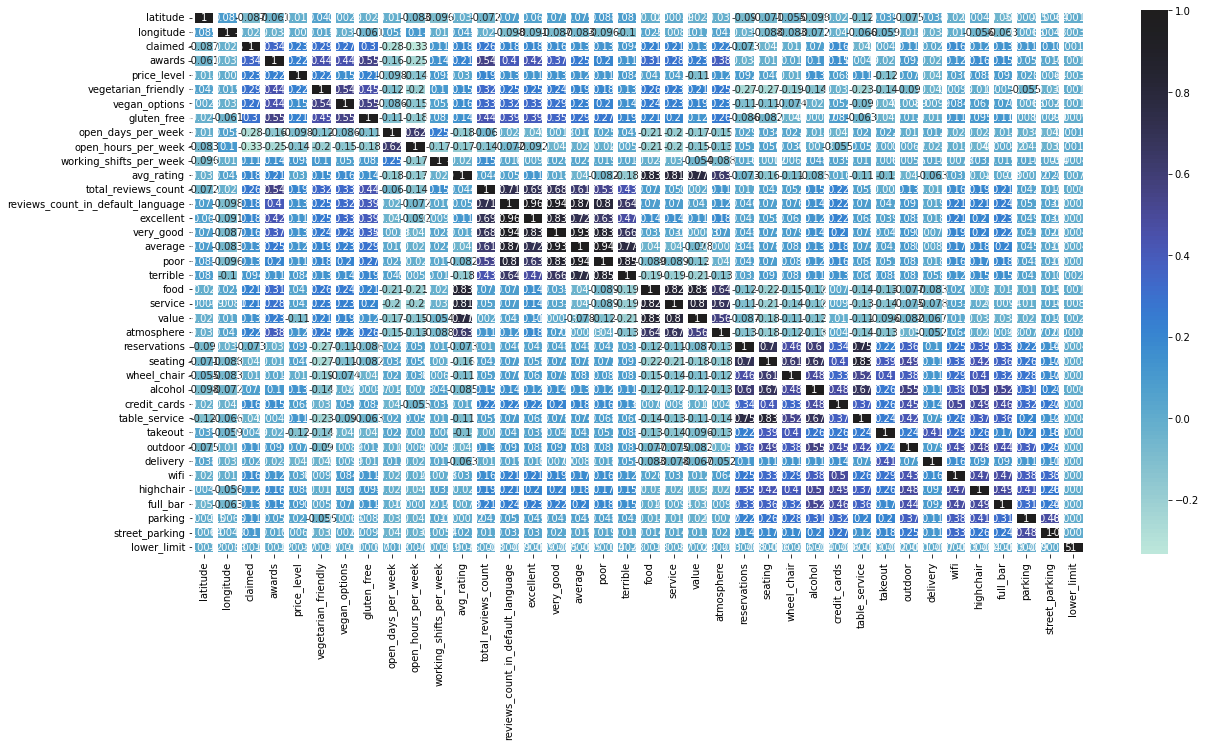

In [120]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(20,10))         # Sample figsize in inches
sns.heatmap(correlations_matrix, ax=ax, linewidth=3.1,annot=True,center=1)

In [121]:
#from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
model = LinearRegression()


In [122]:
y = numericals['lower_limit']
X = numericals.drop('lower_limit', axis = 1)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#scores = cross_val_score(model, X_rand, y_rand, cv=10)

In [125]:
scores = cross_val_score(model, X, y, cv=5)
scores

array([0.06862649, 0.10420053, 0.21408706, 0.08275771, 0.0400214 ])

In [126]:
mean_score = scores.mean()
print(mean_score)

0.1019386364766232


In [127]:
model1 = DecisionTreeRegressor()
from sklearn.linear_model import LinearRegression
model2 = LinearRegression()
from sklearn.neighbors import KNeighborsRegressor
model3 = KNeighborsRegressor()

import numpy as np

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25)

model_pipeline = [model1, model2, model3]
model_names = ['Decision Tree Regressor', 'Linear Regression', 'KNN']
scores = {}
for model, model_name in zip(model_pipeline, model_names):
    mean_score = np.mean(cross_val_score(model, X_train, y_train, cv=10))
    scores[model_name] = mean_score
print(scores)

C:\Users\KIMERA\.conda\envs\iron_hack_DA\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
C:\Users\KIMERA\.conda\envs\iron_hack_DA\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
C:\Users\KIMERA\.conda\envs\iron_hack_DA\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
C:\Users\KIMERA\.conda\envs\iron_hack_DA\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
C:\Users\KIMERA\.conda\envs\iron_hack_DA\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.w

{'Decision Tree Regressor': -1.2804750160542493, 'Linear Regression': 0.12173095818050558, 'KNN': -0.059960564809059216}


In [128]:
# lm = linear_model.LinearRegression()
# model = lm.fit(X_train,y_train)

In [129]:
# model.predict(X_test,y_test)
# predictions = lm.predict(X_train)
# r2_score(y_train, predictions)

## Features Selection using PCA

In [130]:
from sklearn.decomposition import PCA

In [131]:
pca = PCA()
pca.fit(X_train)

PCA()

In [132]:
pca.explained_variance_ratio_.round(2)

array([0.94, 0.05, 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  ])

### Not that big difference between 10 & 20 features

In [133]:
pca.explained_variance_ratio_[:20].sum()

0.9999876865629406

In [134]:
pca.explained_variance_ratio_[:10].sum()

0.9997780608348975

In [135]:
pca = PCA(n_components = 5)
pca.fit(X_train)

PCA(n_components=5)

In [136]:
pca.explained_variance_ratio_

array([9.36773199e-01, 4.51489117e-02, 1.39543397e-02, 2.47063444e-03,
       4.50320131e-04])

In [138]:
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_val)

In [140]:
lm = LinearRegression()
model = lm.fit(X_train_pca,y_train)

In [141]:
# model.predict(X_test,y_test)
predictions = lm.predict(X_train_pca)
r2_score(y_train, predictions)

0.031110677959567234

# WILL IMPROVE THE MODEL TOMORROW